In [1]:
from pyspark.sql import SparkSession 
 
spark_session = SparkSession.builder\
        .master("spark://192.168.2.129:7077") \
        .appName("test_justus_csv_")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max", 4)\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/15 02:37:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
msd_df = spark_session.read.csv('hdfs://192.168.2.129:50000/hdfs/data/MSD_Sub_as_CSV.csv', header=True)

In [3]:
msd_df.rdd.getNumPartitions()

1

In [4]:
#msd_df.printSchema()

In [5]:
#msd_df.show()

#### Famous (Familiarity above 0.5) artists with more than 6 fairly successful (hotness above 0.5) songs in the list that are most inconsistent in the hotness of their songs (std)

In [30]:
%%time
import time

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import isnan
from pyspark.sql.functions import col
start_time = time.time()
msd_df.select('ArtistName','ArtistFamiliarity', 'Title', 'Duration', 'Hotness', 'Year')\
                        .filter(~isnan('Hotness'))\
                        .filter(col('ArtistFamiliarity')>0.5)\
                        .filter(col('Hotness')>0.5)\
                        .groupBy('ArtistName')\
                        .agg(F.mean('Hotness'),\
                             F.max('Hotness'),\
                             F.mean('Duration'),\
                             F.mean('ArtistFamiliarity'),\
                             F.stddev('Hotness'),\
                             F.count('Title'))\
                        .filter(col('count(Title)')>6)\
                        .orderBy(col('stddev_samp(Hotness)').desc())\
                        .show()
end_time = time.time()
print("Exec-time:", (end_time - start_time))


+--------------------+------------------+------------------+------------------+----------------------+--------------------+------------+
|          ArtistName|      avg(Hotness)|      max(Hotness)|     avg(Duration)|avg(ArtistFamiliarity)|stddev_samp(Hotness)|count(Title)|
+--------------------+------------------+------------------+------------------+----------------------+--------------------+------------+
|                Muse|0.7480942699362044|0.9313464882695122|236.26963285714282|    0.9290302874411606| 0.12458007284290674|           7|
|           Van Halen|0.6828456606107542|0.8244821296824321|      235.04281125|    0.7446412459327761| 0.10233802913168039|           8|
|        Phil Collins|0.6247220699051724|0.8234792303926979|      255.60444375|    0.6559214175882668| 0.09874507076675376|           8|
|           Radiohead|0.6216358888222108|0.7750235506643848|215.53587285714283|    0.8999349522317316| 0.08714805920987949|           7|
|Casiotone For The...|0.6791804513817212|

##### Visualization

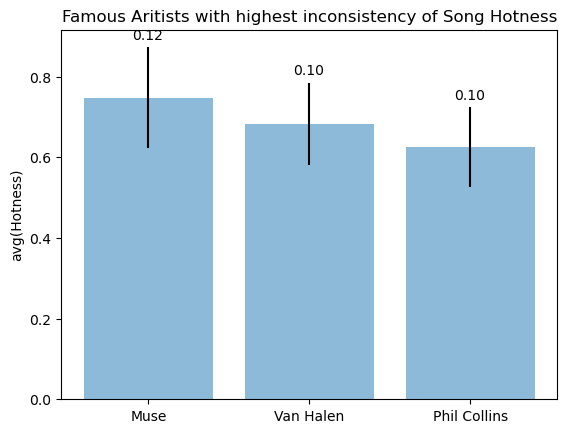

In [18]:
import matplotlib.pyplot as plt

result_df = msd_df.select('ArtistName', 'ArtistFamiliarity', 'Title', 'Duration', 'Hotness', 'Year') \
    .filter(~isnan('Hotness')) \
    .filter(col('ArtistFamiliarity') > 0.5) \
    .filter(col('Hotness') > 0.5) \
    .groupBy('ArtistName') \
    .agg(F.mean('Hotness'), \
         F.max('Hotness'), \
         F.mean('Duration'), \
         F.mean('ArtistFamiliarity'), \
         F.stddev('Hotness'), \
         F.count('Title')) \
    .filter(col('count(Title)') > 6) \
    .orderBy(col('stddev_samp(Hotness)').desc()) \
    .limit(3) \
    .collect()

artists = [row['ArtistName'] for row in result_df]
hotness_means = [row['avg(Hotness)'] for row in result_df]
hotness_stdevs = [row['stddev_samp(Hotness)'] for row in result_df]

x_pos = [i for i, _ in enumerate(artists)]
fig, ax = plt.subplots()
rects1 = ax.bar(x_pos, hotness_means, color='tab:blue', alpha=0.5, yerr=hotness_stdevs)
for i, v in enumerate(hotness_stdevs):
    ax.text(i-0.1, hotness_means[i] + v + 0.02, "{:.2f}".format(v), fontsize=10)

plt.xticks(x_pos, artists)
plt.ylabel('avg(Hotness)')
plt.title('Famous Aritists with highest inconsistency of Song Hotness')
plt.show()


### Development of Songduration and BPM over the decades

In [31]:
%%time

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import isnan
from pyspark.sql.functions import col


msd_df = msd_df.withColumn("Duration", msd_df["Duration"].cast(DoubleType()))
msd_df = msd_df.withColumn("Tempo", msd_df["Tempo"].cast(DoubleType()))


df_result = msd_df.select('Year', 'Tempo', 'Duration', 'ArtistFamiliarity')\
    .filter(msd_df.Year.between(1950,2009))\
    .groupBy(F.concat(F.floor((msd_df.Year - 1960) / 10) * 10 + 1960, F.lit('s')).alias('Decade'))\
    .agg(F.mean('Duration'),\
         F.min('Duration'),\
         F.mean('Tempo'),\
         F.max('Tempo'),\
         F.mean('ArtistFamiliarity'),\
         F.count('Year'))\
    .orderBy(col("Decade").desc())\
    .show()

+------+------------------+-------------+------------------+----------+----------------------+-----------+
|Decade|     avg(Duration)|min(Duration)|        avg(Tempo)|max(Tempo)|avg(ArtistFamiliarity)|count(Year)|
+------+------------------+-------------+------------------+----------+----------------------+-----------+
| 2000s|  239.910531840346|      1.04444|125.70020369642137|   258.677|    0.6419966288405928|       2543|
| 1990s|243.39181220746903|      3.99628| 124.2187668049793|   232.709|    0.6125768860773328|       1205|
| 1980s| 235.0795113895216|       1.2273|126.29023690205011|    241.52|    0.6436180514723492|        439|
| 1970s|249.01221613821133|      38.3473|130.81615040650402|   237.466|    0.6266644359577476|        246|
| 1960s|194.02241605839413|     72.33261| 116.7104598540146|   231.089|    0.5874146301491647|        137|
| 1950s|164.45864933333328|     80.03873|          116.1088|   196.303|    0.6022447857598824|         30|
+------+------------------+----------

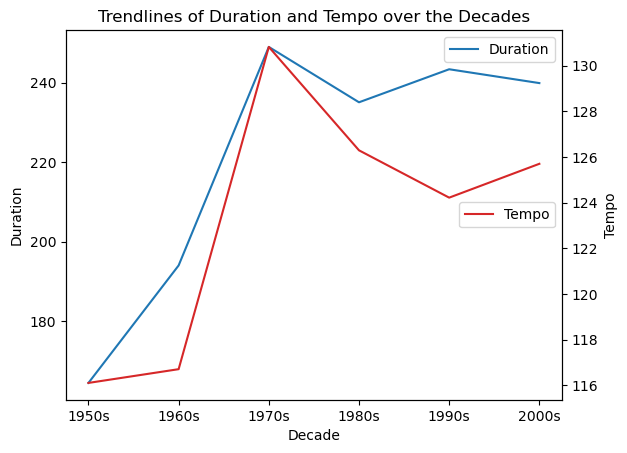

In [24]:
import matplotlib.pyplot as plt

df_pandas = df_result.toPandas()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

df_pandas.plot(x='Decade', y='avg(Duration)', ax=ax1, label='Duration', color='tab:blue')
df_pandas.plot(x='Decade', y='avg(Tempo)', ax=ax2, label='Tempo', color='tab:red')

ax1.set_xlabel('Decade')
ax1.set_ylabel('Duration')
ax2.set_ylabel('Tempo')
ax2.legend(loc = 'center right')
plt.title('Trendlines of Duration and Tempo over the Decades')

plt.show()



In [101]:
spark_session.stop()